# dataload, EDA and baseline

In [490]:
#imports

# data processing
import numpy as np 
import pandas as pd 
import random
import collections
from collections import defaultdict

# visualization 
import matplotlib.image as img
import matplotlib.pyplot as plt
import seaborn as sns
from pylab import * 

sns.set_style("whitegrid")

# files operations
import os
from pathlib import Path
from os import listdir
from os.path import isfile, join
from PIL import Image
from shutil import copy
from shutil import copyfile
from shutil import copytree, rmtree

# modelling
import sklearn
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, classification_report
from sklearn.metrics import multilabel_confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn import preprocessing
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression

# deep learning
import tensorflow
import keras
from keras.preprocessing.image import ImageDataGenerator
from keras.preprocessing import image as keras_image
from tensorflow.keras.utils import load_img, img_to_array

In [491]:
#setting data source
ld = os.listdir("garbage_classification/")
ld.pop(0)
path = "garbage_classification/"

In [492]:
#class imbalance - depending on models performance it could be addressed by multiplication and modification of underrepresented class or downsampling
for category in ld:
    count_category = 0
    for photo in os.listdir(path + category):
        count_category += 1
    print(str(category) + " has " + str(count_category) + " photos")  

green-glass has 629 photos
white-glass has 775 photos
brown-glass has 607 photos
plastic has 865 photos


In [493]:
#data load
img_array=[]
class_name=[]
img_name=[]

def create_image_df(img_folder): # path_resized_baseline_train
   
    for img_class_subfolder in os.listdir(img_folder):
        if img_class_subfolder == '.DS_Store':
            continue
        for file in os.listdir(os.path.join(img_folder, img_class_subfolder)):
       
            image_path= os.path.join(img_folder, img_class_subfolder,  file)
            
            img = tensorflow.keras.utils.load_img(image_path, target_size=(71, 71),color_mode = "rgb") #changed from 128x128
            x = tensorflow.keras.utils.img_to_array(img)
            x = x/255
            x = np.expand_dims(x, axis=0)
            x = np.transpose(x.flatten())
            
            # append to list
            img_array.append(x)
            class_name.append(img_class_subfolder)
            img_name.append(file)
    
    # create df and concatenate 3 elements
    df_img_array = pd.DataFrame(data = img_array)
    df_name = pd.DataFrame({'img_id':img_name})    
    df_class = pd.DataFrame({'class_name':class_name})
            
    # merge dataframes
    img_df_temp = df_img_array.merge(df_name, left_index=True, right_index=True)
    img_df = img_df_temp.merge(df_class, left_index=True, right_index=True)
               
    return img_df

In [494]:
df = create_image_df(path+'/')

In [495]:
# reordering columns
cols_to_order = ['img_id', 'class_name']
new_columns = cols_to_order + (df.columns.drop(cols_to_order).tolist())
image_df = df[new_columns]
image_df.head()

,img_id,class_name,0,1,2,3,4,5,6,7,...,15113,15114,15115,15116,15117,15118,15119,15120,15121,15122
0,green-glass221.jpg,green-glass,0.486275,0.505882,0.490196,0.490196,0.509804,0.494118,0.494118,0.513726,...,0.509804,0.552941,0.537255,0.501961,0.552941,0.537255,0.501961,0.549020,0.533333,0.498039
1,green-glass547.jpg,green-glass,0.827451,0.800000,0.768627,0.847059,0.819608,0.788235,0.858824,0.831373,...,0.890196,0.988235,0.960784,0.921569,0.968627,0.941176,0.901961,0.909804,0.870588,0.835294
2,green-glass553.jpg,green-glass,0.921569,0.921569,0.921569,0.937255,0.937255,0.937255,0.992157,0.992157,...,0.913725,0.996078,0.996078,0.996078,0.937255,0.937255,0.937255,0.933333,0.933333,0.933333
3,green-glass235.jpg,green-glass,0.909804,0.925490,0.972549,0.901961,0.917647,0.964706,0.901961,0.909804,...,0.925490,0.850980,0.862745,0.921569,0.862745,0.870588,0.921569,0.866667,0.874510,0.925490
4,green-glass209.jpg,green-glass,0.827451,0.752941,0.686275,0.831373,0.756863,0.690196,0.835294,0.760784,...,0.635294,0.800000,0.729412,0.635294,0.800000,0.729412,0.635294,0.815686,0.745098,0.650980


In [496]:
# pickle df
#image_df.to_pickle("image_df.pickle")

In [497]:
#defining features and target
features = image_df.iloc[:,2:]
target = image_df.iloc[:,1:2]

#train/val split 80%/20%
X_train, X_val, y_train, y_val = train_test_split(features, target, test_size=.20, random_state=42)

#defining labels
y_train_label = y_train.values.astype(object)
y_val_label = y_val.values.astype(object)

#encoding cathegorical labels into numerical
encoder = preprocessing.LabelEncoder()
encoder.fit(y_train_label.ravel())
y_train = encoder.transform(y_train_label.ravel())
encoder.fit(y_val_label.ravel())
y_val = encoder.transform(y_val_label.ravel())

#scaling
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)

# Logistic Regression Model for performance baseline

In [498]:
#Linear dimensionality reduction using Singular Value Decomposition of the data to project it to a lower dimensional space. The input data is centered but not scaled for each feature before applying the SVD.
pca = PCA(n_components=2)

X_train_2PC = pca.fit_transform(X_train_scaled)
X_val_2PC = pca.transform(X_val_scaled)

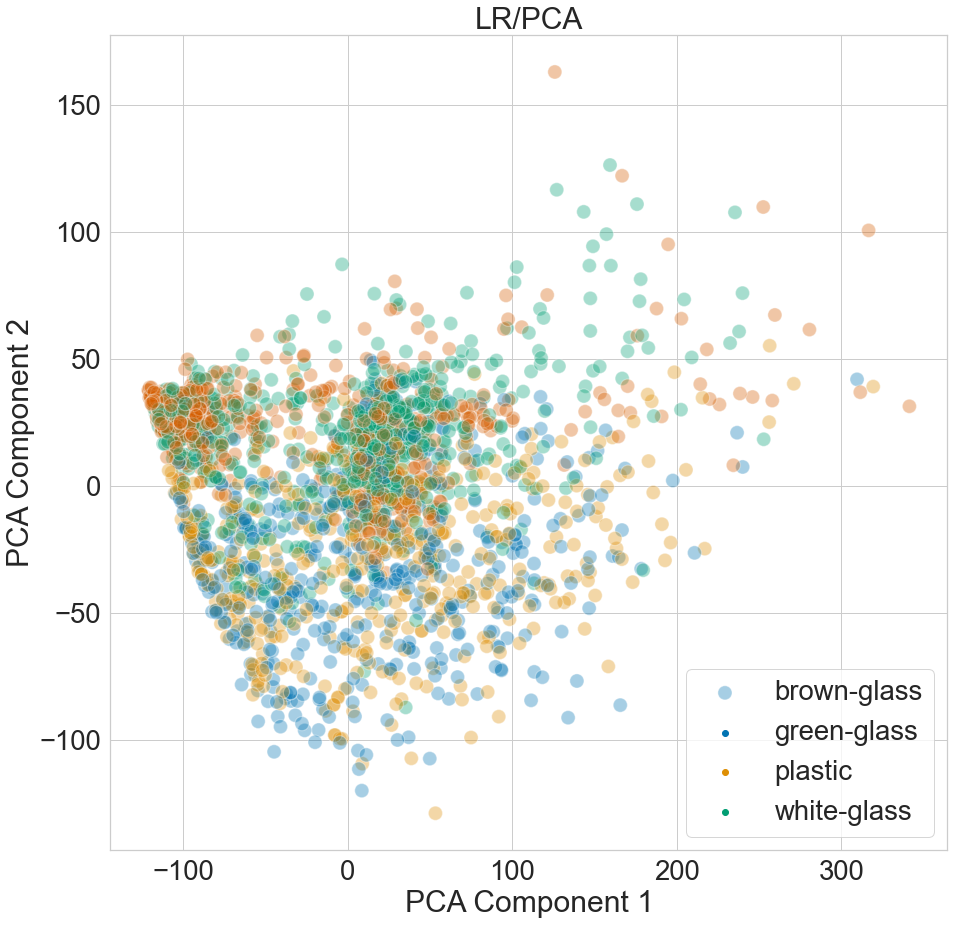

In [507]:
plt.figure(figsize=(15,15))
sns.set_style("whitegrid")
sns.scatterplot(x=X_train_2PC[:, 0], y=X_train_2PC[:, 1], 
                hue=y_train, alpha=.35,
                palette=sns.color_palette("colorblind", 4),
                s=200)
plt.legend(['brown-glass', 'green-glass', 'plastic', 'white-glass'], loc='lower right')
xlabel("PCA Component 1")
ylabel("PCA Component 2")
title("LR/PCA")
plt.savefig('LR_PCA.jpg');

In [508]:
lr = LogisticRegression(multi_class = 'multinomial', solver = 'lbfgs')
lr.fit(X_train_2PC, y_train)

#prediction
y_pred_t = lr.predict(X_train_2PC)
y_pred = lr.predict(X_val_2PC)

#F1 and accuracy
f1_t = f1_score(y_train, y_pred_t, average = 'macro')
accuracy_t = accuracy_score(y_train, y_pred_t)
f1 = f1_score(y_val, y_pred, average = 'macro')
accuracy = accuracy_score(y_val, y_pred)

print(f'Logistic Regression | Training Accuracy: \t{accuracy_t} | Training F1 score: \t{f1_t} \n')
print(f'Logistic Regression | Validation Accuracy: \t{accuracy} | Validation F1 score: \t{f1} \n')

Logistic Regression | Training Accuracy: 	0.4930434782608696 | Training F1 score: 	0.47043650232996576 

Logistic Regression | Validation Accuracy: 	0.4739583333333333 | Validation F1 score: 	0.4593363134855781 



**Validation F1 score: 0.459**

In [509]:
#when used scaled data, with no PCA scores are similar to random forest but it starts to be demanding for cpu

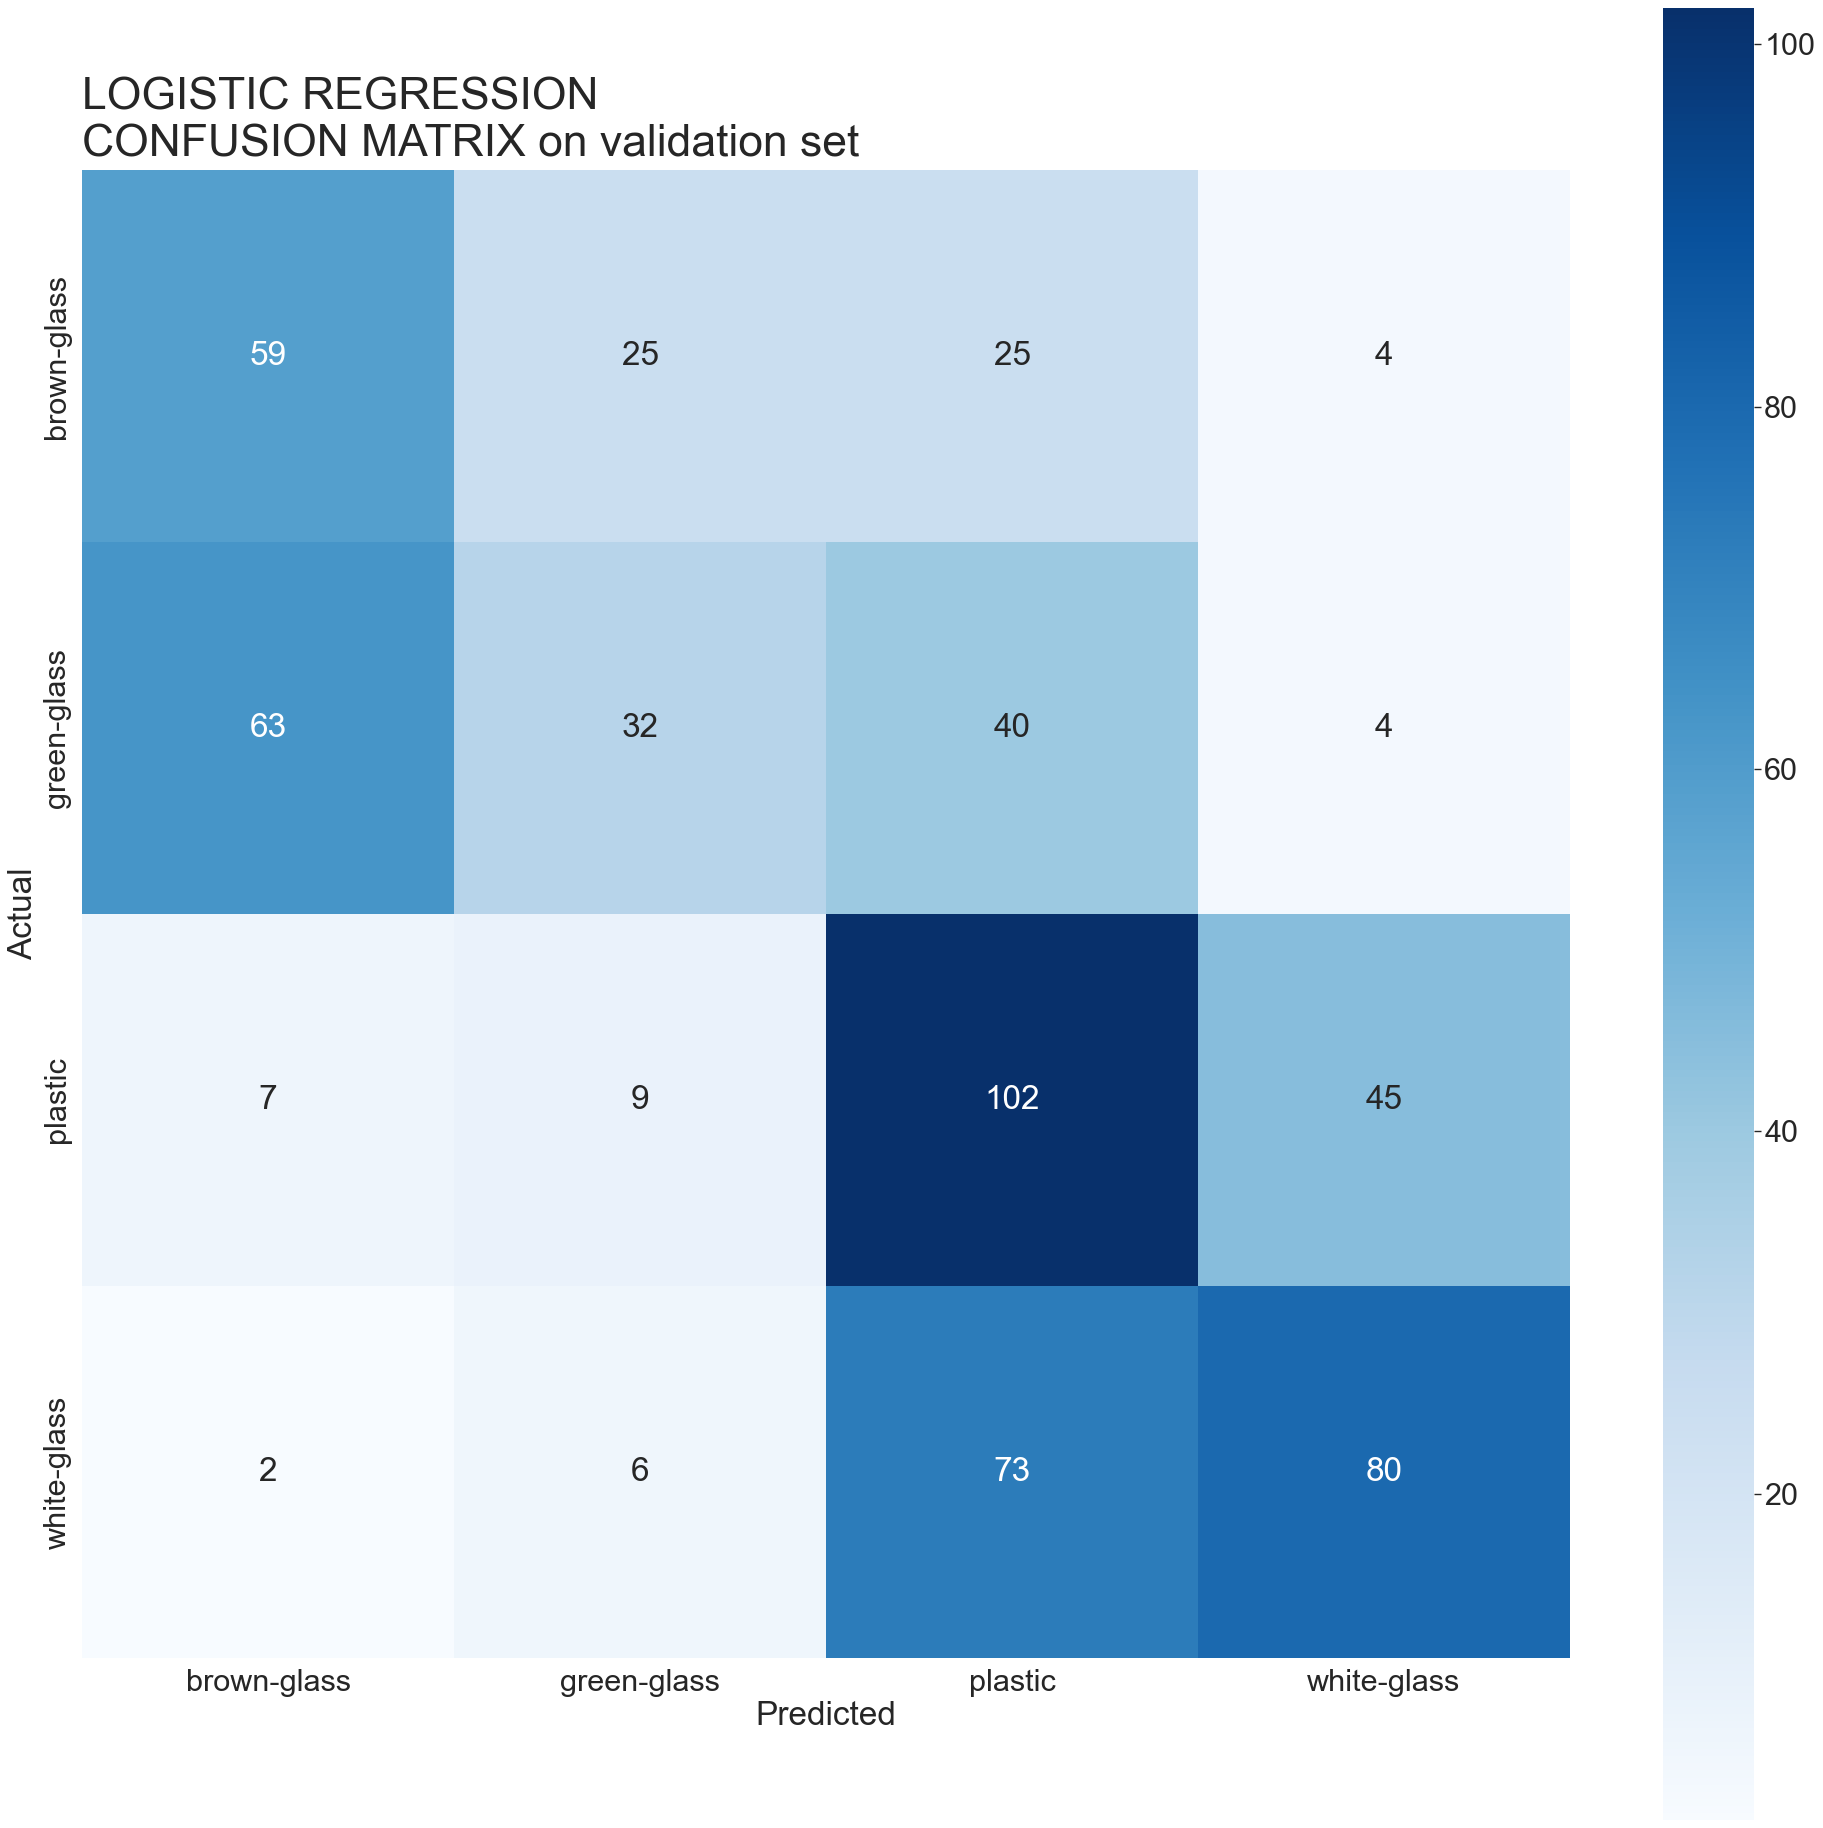

In [510]:
#Confusion Matrix
rf_confusion = confusion_matrix(y_val, y_pred)
plt.figure(figsize=(30, 30), dpi=80)
ax = plt.subplot()
sns.heatmap(rf_confusion, cmap = "Blues", annot=True, square=True, fmt=".0f")
sns.set(font_scale=2.5)

plt.xlabel('Predicted',fontsize = 30)
plt.ylabel('Actual',fontsize = 30)
ax.xaxis.set_ticklabels(['brown-glass', 'green-glass', 'plastic', 'white-glass'])
ax.yaxis.set_ticklabels(['brown-glass', 'green-glass', 'plastic', 'white-glass'])
plt.title('LOGISTIC REGRESSION\nCONFUSION MATRIX on validation set', fontsize = 40, loc = 'left', pad = 12)
plt.savefig('LR_CONFUSION_MATRIX.jpg');

verification

In [527]:
def show_and_test(image):
    i_pr = y_pred[image]
    i_va = y_val[image]
    i_li = ['brown-glass', 'green-glass', 'plastic', 'white-glass']
    i_fi = image_df.iloc[X_val.iloc[image].name].img_id
    print("Predicted: "+i_li[i_pr]+"   Actual: "+i_li[i_va]+"\n\nFile: "+i_fi)    
    img = load_img('garbage_classification/'+i_li[i_va]+'/'+i_fi)
    return img

Predicted: plastic   Actual: green-glass

File: green-glass198.jpg


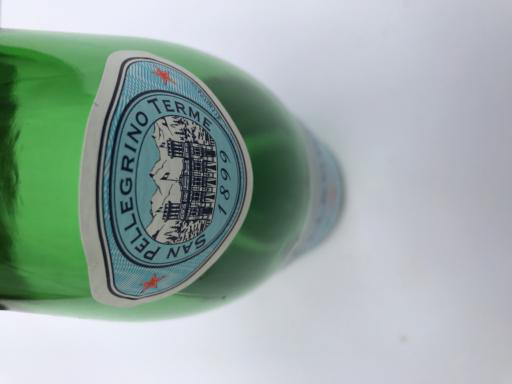

In [539]:
show_and_test(np.random.randint(0, len(y_pred)))

# Neural Network Model

In [540]:
# display and plotting imports
%pylab inline 
import seaborn as sns
sns.set()
from IPython.display import SVG

import pandas as pd

# sklearn imports
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.cluster import KMeans

# keras imports
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.utils import model_to_dot
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Dense, Activation, Dropout
from tensorflow.keras.layers import Input, Embedding, Bidirectional, LSTM

# gensim import for word2vec loading
from gensim.models.keyedvectors import KeyedVectors

%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


/Users/krystiank/opt/anaconda3/lib/python3.8/site-packages/IPython/core/magics/pylab.py:162: UserWarning: pylab import has clobbered these variables: ['copy', 'random', 'fft', 'power']
`%matplotlib` prevents importing * from pylab and numpy
  warn("pylab import has clobbered these variables: %s"  % clobbered +


In [541]:
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Dense, Activation, Dropout
from tensorflow.keras.layers import Input, Embedding, Bidirectional, LSTM
from keras import backend as K

#Solution that works - erified it with Keras Precision and Recall class metrics
def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

def recall_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def precision_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

In [542]:
y_train_cat = to_categorical(y_train)
y_val_cat = to_categorical(y_val)
X_train_scaled.shape

(2300, 15123)

In [543]:
NN = Sequential()

NN.add(Dense(512,  input_dim = X_train_scaled.shape[1])) 
NN.add(Activation('relu'))

NN.add(Dense(256))
NN.add(Activation('relu'))
NN.add(Dropout(0.1)) #after many trials

NN.add(Dense(128, name = '2D_layer'))
NN.add(Activation('relu')) 
#NN.add(Dropout(0.1))

NN.add(Dense(4))
NN.add(Activation('softmax'))

NN.compile(loss='categorical_crossentropy',metrics=[f1_m])


run_hist = NN.fit(X_train_scaled, y_train_cat, validation_data = (X_val_scaled, y_val_cat), epochs=50, verbose=1,callbacks=[
        keras.callbacks.EarlyStopping(patience=8, verbose=1, restore_best_weights=True),
        keras.callbacks.ReduceLROnPlateau(factor=.5, patience=3, verbose=1),
    ]) 


Epoch 1/50


2022-10-28 19:12:00.910961: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


72/72 [==============================] - ETA: 0s - loss: 6.4289 - f1_m: 0.5043

2022-10-28 19:12:05.551053: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


72/72 [==============================] - 6s 55ms/step - loss: 6.4289 - f1_m: 0.5043 - val_loss: 2.9396 - val_f1_m: 0.5596 - lr: 0.0010
Epoch 2/50
72/72 [==============================] - 3s 38ms/step - loss: 2.6253 - f1_m: 0.6015 - val_loss: 1.4060 - val_f1_m: 0.6309 - lr: 0.0010
Epoch 3/50
72/72 [==============================] - 3s 35ms/step - loss: 1.6477 - f1_m: 0.6593 - val_loss: 1.1487 - val_f1_m: 0.6593 - lr: 0.0010
Epoch 4/50
72/72 [==============================] - 2s 32ms/step - loss: 1.3805 - f1_m: 0.6974 - val_loss: 1.5077 - val_f1_m: 0.6727 - lr: 0.0010
Epoch 5/50
72/72 [==============================] - 2s 33ms/step - loss: 1.0979 - f1_m: 0.7139 - val_loss: 1.4117 - val_f1_m: 0.6329 - lr: 0.0010
Epoch 6/50
72/72 [==============================] - ETA: 0s - loss: 0.9599 - f1_m: 0.7398
Epoch 6: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
72/72 [==============================] - 3s 38ms/step - loss: 0.9599 - f1_m: 0.7398 - val_loss: 1.5922 - val_f1_m: 

**Validation F1 score: 0.803**

In [544]:
NN.summary()

Model: "sequential_23"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_79 (Dense)            (None, 512)               7743488   
                                                                 
 activation_56 (Activation)  (None, 512)               0         
                                                                 
 dense_80 (Dense)            (None, 256)               131328    
                                                                 
 activation_57 (Activation)  (None, 256)               0         
                                                                 
 dropout_13 (Dropout)        (None, 256)               0         
                                                                 
 2D_layer (Dense)            (None, 128)               32896     
                                                                 
 activation_58 (Activation)  (None, 128)             

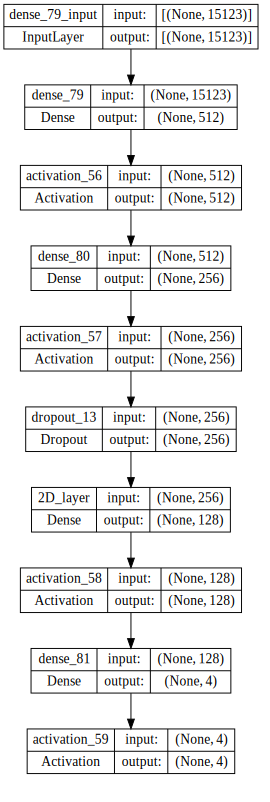

In [545]:
SVG(model_to_dot(NN, show_shapes=True, dpi=70).create(prog='dot', format='svg'))

In [546]:
feature_extractor = \
    Model(inputs=NN.input, outputs=NN.get_layer('2D_layer').output) 

X_train_NN_features_2d = feature_extractor.predict(X_train_scaled)
X_test_NN_features_2d = feature_extractor.predict(X_val_scaled)

20/72 [=======>......................] - ETA: 0s

2022-10-28 19:14:00.230181: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


18/18 [==============================] - 0s 4ms/step


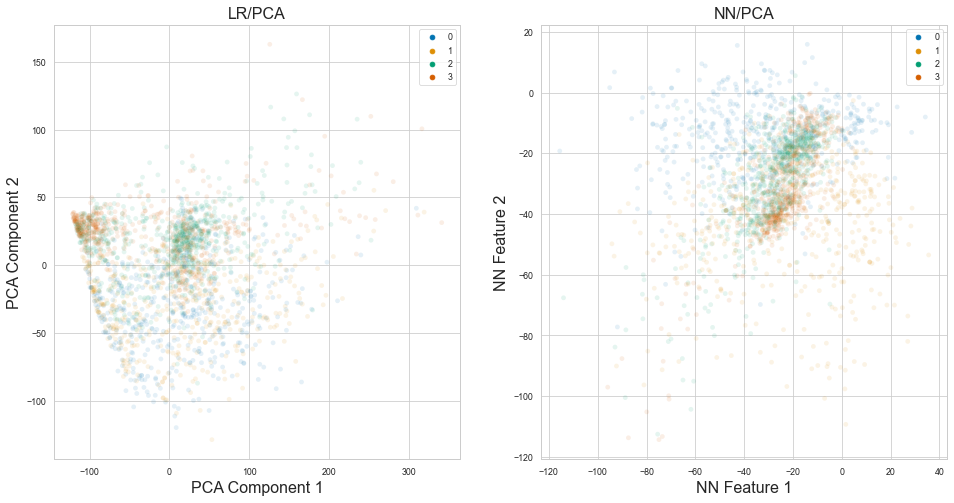

In [583]:
fig, axes = plt.subplots(1, 2, figsize=(16, 8))



sns.scatterplot(
    x=X_train_2PC[:, 0],
    y=X_train_2PC[:, 1],
    hue=y_train,
    alpha=.1,
    palette=sns.color_palette("colorblind", 4),
    ax=axes[0],
)
axes[0].set_title("LR/PCA")
axes[0].set_xlabel("PCA Component 1")
axes[0].set_ylabel("PCA Component 2")


sns.scatterplot(
    x=X_train_NN_features_2d[:, 0],
    y=X_train_NN_features_2d[:, 1],
    hue=y_train,
    alpha=.1,
    palette=sns.color_palette("colorblind", 4),
    ax=axes[1],
)

sns.set_context("paper", rc={"font.size":15,"axes.titlesize":16,"axes.labelsize":16})  
sns.set_style("whitegrid")
axes[1].set_title("NN/PCA")
axes[1].set_xlabel("NN Feature 1")
axes[1].set_ylabel("NN Feature 2")
plt.savefig('NN_PCA.jpg');

dict_keys(['loss', 'f1_m', 'val_loss', 'val_f1_m', 'lr'])


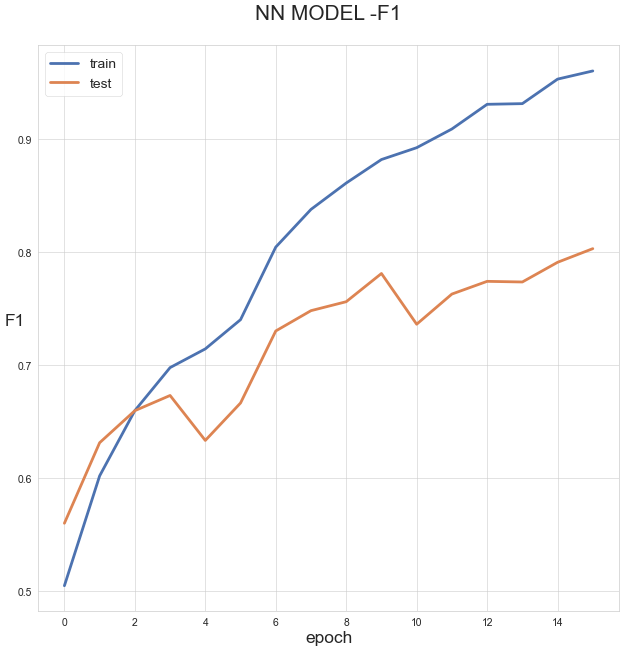

<Figure size 432x288 with 0 Axes>

In [645]:
history=run_hist
print(history.history.keys())
plt.figure(figsize=(15, 15), dpi=50)
# summarize history for accuracy
plt.plot(history.history['f1_m'], linewidth = 4)
plt.plot(history.history['val_f1_m'], linewidth = 4)
plt.title('NN MODEL -F1\n')
plt.ylabel('F1',rotation=0)
plt.xlabel('epoch')
ax.set(ylim=(0, 100))
plt.legend(['train', 'test'], loc='upper left', fontsize = 20)
sns.set_context("paper", rc={"font.size":15,"axes.titlesize":30,"axes.labelsize":25})  
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.show()
plt.savefig('NN_F1.jpg');

In [646]:
predictions = NN.predict(X_val_scaled)
y_pred = np.argmax(predictions, axis=1)

18/18 [==============================] - 0s 8ms/step


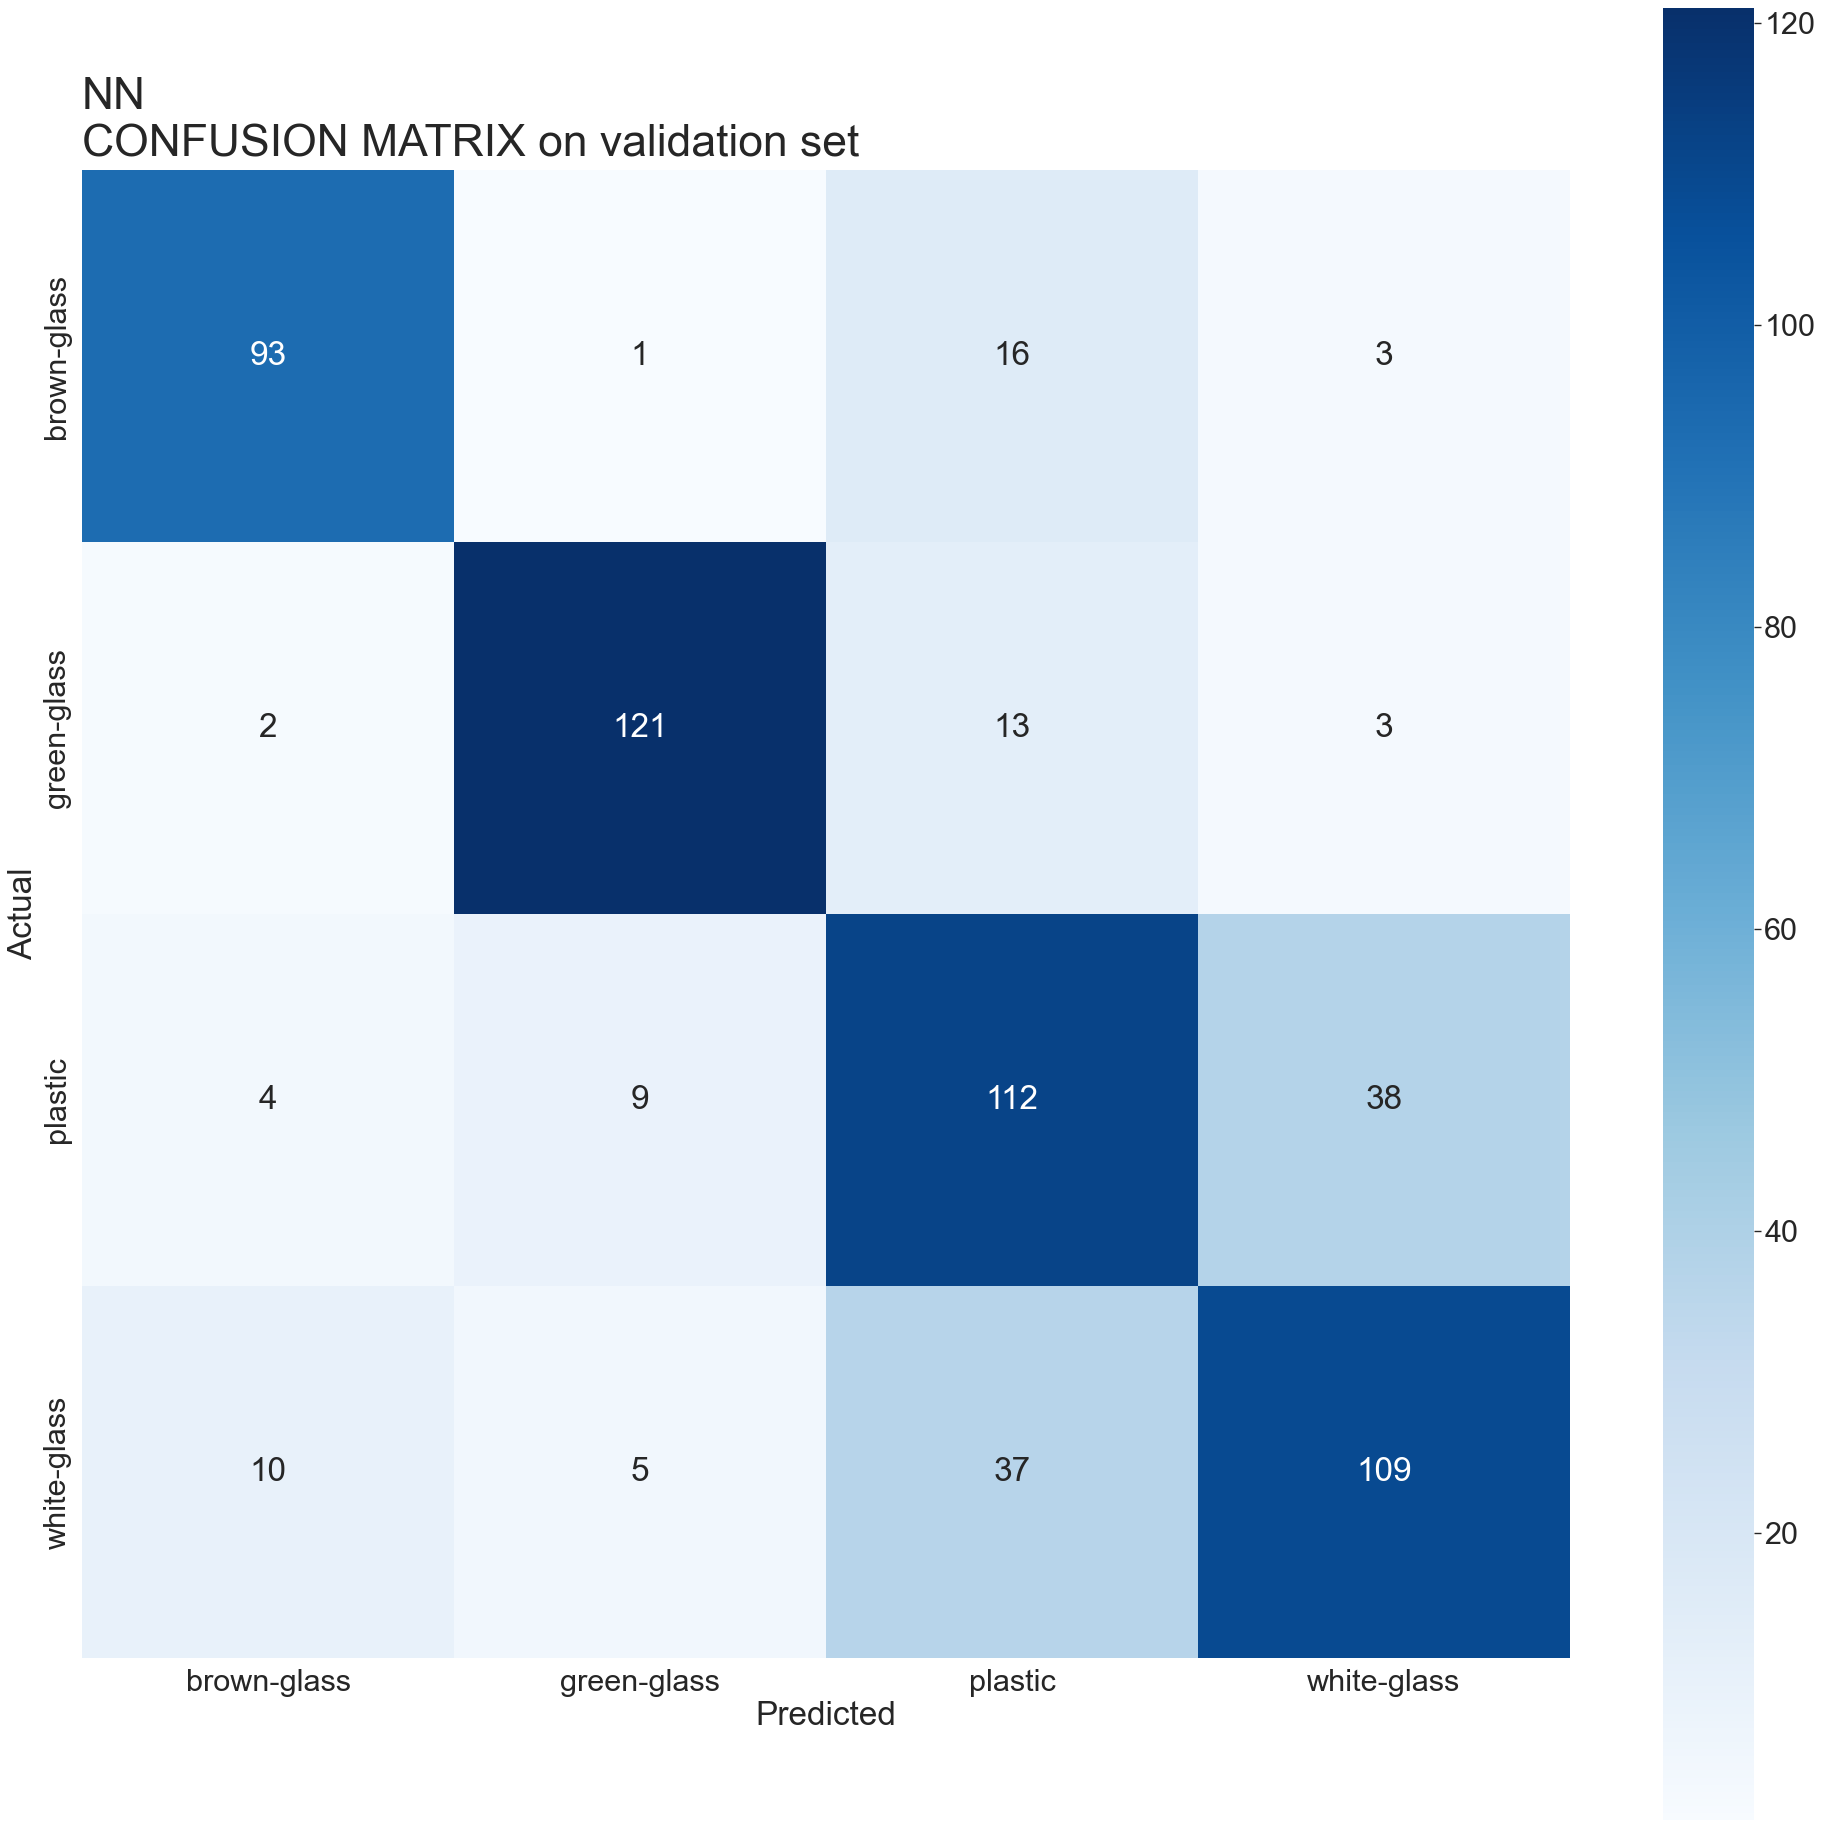

In [650]:
#Confusion Matrix
rf_confusion = confusion_matrix(y_val, y_pred)
plt.figure(figsize=(30, 30), dpi=80)
ax = plt.subplot()
sns.heatmap(rf_confusion, cmap = "Blues", annot=True, square=True, fmt=".0f")
sns.set(font_scale=2.5)

plt.xlabel('Predicted',fontsize = 30)
plt.ylabel('Actual',fontsize = 30)
ax.xaxis.set_ticklabels(['brown-glass', 'green-glass', 'plastic', 'white-glass'])
ax.yaxis.set_ticklabels(['brown-glass', 'green-glass', 'plastic', 'white-glass'])
plt.title('NN\nCONFUSION MATRIX on validation set', fontsize = 40, loc = 'left', pad = 12)
plt.savefig('NN_PCA.jpg');

In [653]:
def show_and_test(image):
    i_pr = y_pred[image]
    i_va = y_val[image]
    i_li = ['brown-glass', 'green-glass', 'plastic', 'white-glass']
    i_fi = image_df.iloc[X_val.iloc[image].name].img_id
    print("Predicted: "+i_li[i_pr]+"   Actual: "+i_li[i_va]+"\n\nFile: "+i_fi)   
    img = load_img('garbage_classification/'+i_li[i_va]+'/'+i_fi)
    return img

Predicted: white-glass   Actual: plastic

File: plastic639.jpg


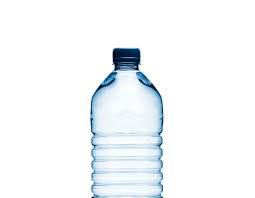

In [662]:
show_and_test(np.random.randint(0, len(y_pred)))

# CCN Model

In [663]:
from sklearn.datasets import fetch_openml
import numpy as np
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical

In [664]:
features = image_df.iloc[:,2:]
target = image_df.iloc[:,1:2]

In [665]:
#train/val split 80%/20%
X_train, X_val, y_train, y_val = train_test_split(features, target, test_size=.20, random_state=42)

X_i=X_val
X_train = X_train.values.reshape((-1,71,71,3)) 
X_val = X_val.values.reshape((-1,71,71,3)) 

#encoding cathegorical labels into numerical
encoder = preprocessing.LabelEncoder()
encoder.fit(y_train_label.ravel())
y_train = encoder.transform(y_train_label.ravel())
encoder.fit(y_val_label.ravel())
y_val = encoder.transform(y_val_label.ravel())
y_train_cat = to_categorical(y_train)
y_val_cat = to_categorical(y_val)

X_train.shape

(2300, 71, 71, 3)

In [672]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, MaxPooling2D, Flatten, GlobalAveragePooling2D, InputLayer

NN = Sequential()

NN.add(InputLayer(input_shape=X_train.shape[1:]))

# Conv block 1.  You can add more conv steps to
# each block to increase model capacity.
NN.add(Conv2D(filters=32, kernel_size=3, activation='relu', padding='same'))
#NN.add(Conv2D(filters=16, kernel_size=3, activation='relu', padding='same'))
NN.add(MaxPooling2D())

# Conv block 2 - note we increase filter dimension as we move
# further into the network. You can add more conv steps to
# each block to increase model capacity.
NN.add(Conv2D(filters=64, kernel_size=3, activation='relu', padding='same'))
# NN.add(Conv2D(filters=16, kernel_size=3, activation='relu', padding='same'))
NN.add(MaxPooling2D())

# Conv block 3 - The conv blocks should be ended with either a flatten
# layer or a global pooling layer. These transform the 2D layers to 1D
# to match the following dense layers.
NN.add(Conv2D(filters=128, kernel_size=3, activation='relu', padding='same'))
#NN.add(Conv2D(filters=256, kernel_size=3, activation='relu', padding='same'))

NN.add(GlobalAveragePooling2D())

# Fully connected block - flattening followed by dense and output layers
# NN.add(Flatten())
#NN.add(Dense(512, activation='relu')) 
NN.add(Dense(256, activation='relu'))
NN.add(Dense(128, activation='relu',name = '2D_layer'))
NN.add(Dense(4, activation='softmax'))  

NN.compile(
    loss='categorical_crossentropy',
    optimizer='adam',
    metrics=[f1_m],
)
NN.summary()
run_hist = NN.fit(X_train, y_train_cat, validation_data = (X_val, y_val_cat), epochs=70, verbose=1, callbacks=[
        keras.callbacks.EarlyStopping(patience=8, verbose=1, restore_best_weights=True),
        keras.callbacks.ReduceLROnPlateau(factor=.5, patience=3, verbose=1),
    ]) 

Model: "sequential_30"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_49 (Conv2D)          (None, 71, 71, 32)        896       
                                                                 
 max_pooling2d_30 (MaxPoolin  (None, 35, 35, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_50 (Conv2D)          (None, 35, 35, 64)        18496     
                                                                 
 max_pooling2d_31 (MaxPoolin  (None, 17, 17, 64)       0         
 g2D)                                                            
                                                                 
 conv2d_51 (Conv2D)          (None, 17, 17, 128)       73856     
                                                                 
 global_average_pooling2d_15  (None, 128)            

2022-10-28 20:08:14.644142: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


72/72 [==============================] - ETA: 0s - loss: 1.0920 - f1_m: 0.2678

2022-10-28 20:08:18.856595: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


72/72 [==============================] - 5s 59ms/step - loss: 1.0920 - f1_m: 0.2678 - val_loss: 0.7816 - val_f1_m: 0.6079 - lr: 0.0010
Epoch 2/70
72/72 [==============================] - 3s 36ms/step - loss: 0.6913 - f1_m: 0.6433 - val_loss: 0.7054 - val_f1_m: 0.6299 - lr: 0.0010
Epoch 3/70
72/72 [==============================] - 3s 35ms/step - loss: 0.6413 - f1_m: 0.6938 - val_loss: 0.6327 - val_f1_m: 0.7381 - lr: 0.0010
Epoch 4/70
72/72 [==============================] - 2s 34ms/step - loss: 0.6077 - f1_m: 0.7280 - val_loss: 0.5859 - val_f1_m: 0.7738 - lr: 0.0010
Epoch 5/70
72/72 [==============================] - 3s 35ms/step - loss: 0.5444 - f1_m: 0.7685 - val_loss: 0.5149 - val_f1_m: 0.7926 - lr: 0.0010
Epoch 6/70
72/72 [==============================] - 2s 35ms/step - loss: 0.5368 - f1_m: 0.7604 - val_loss: 0.5341 - val_f1_m: 0.8019 - lr: 0.0010
Epoch 7/70
72/72 [==============================] - 2s 35ms/step - loss: 0.4945 - f1_m: 0.7903 - val_loss: 0.5077 - val_f1_m: 0.8046 - 

72/72 [==============================] - 2s 34ms/step - loss: 0.1550 - f1_m: 0.9383 - val_loss: 0.2949 - val_f1_m: 0.8868 - lr: 6.2500e-05
Epoch 52/70
72/72 [==============================] - 2s 33ms/step - loss: 0.1514 - f1_m: 0.9425 - val_loss: 0.2865 - val_f1_m: 0.8959 - lr: 3.1250e-05
Epoch 53/70
72/72 [==============================] - 2s 34ms/step - loss: 0.1496 - f1_m: 0.9429 - val_loss: 0.2919 - val_f1_m: 0.8986 - lr: 3.1250e-05
Epoch 54/70
72/72 [==============================] - 2s 33ms/step - loss: 0.1492 - f1_m: 0.9458 - val_loss: 0.2871 - val_f1_m: 0.8959 - lr: 3.1250e-05
Epoch 55/70
71/72 [============================>.] - ETA: 0s - loss: 0.1496 - f1_m: 0.9442
Epoch 55: ReduceLROnPlateau reducing learning rate to 1.5625000742147677e-05.
72/72 [==============================] - 2s 34ms/step - loss: 0.1496 - f1_m: 0.9440 - val_loss: 0.2879 - val_f1_m: 0.8951 - lr: 3.1250e-05
Epoch 56/70
72/72 [==============================] - 2s 34ms/step - loss: 0.1472 - f1_m: 0.9450 - va

**Validation F1 score: 0.898**

In [673]:
NN.summary()

Model: "sequential_30"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_49 (Conv2D)          (None, 71, 71, 32)        896       
                                                                 
 max_pooling2d_30 (MaxPoolin  (None, 35, 35, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_50 (Conv2D)          (None, 35, 35, 64)        18496     
                                                                 
 max_pooling2d_31 (MaxPoolin  (None, 17, 17, 64)       0         
 g2D)                                                            
                                                                 
 conv2d_51 (Conv2D)          (None, 17, 17, 128)       73856     
                                                                 
 global_average_pooling2d_15  (None, 128)            

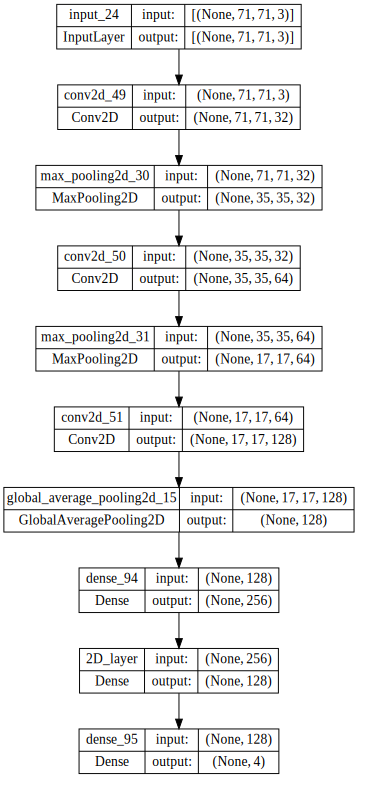

In [674]:
SVG(model_to_dot(NN, show_shapes=True, dpi=70).create(prog='dot', format='svg'))

In [675]:
feature_extractor = \
    Model(inputs=NN.input, outputs=NN.get_layer('2D_layer').output) 

X_train_NN_features_2d = feature_extractor.predict(X_train)
X_test_NN_features_2d = feature_extractor.predict(X_val)

 1/72 [..............................] - ETA: 11s

2022-10-28 20:12:43.468599: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


18/18 [==============================] - 0s 7ms/step


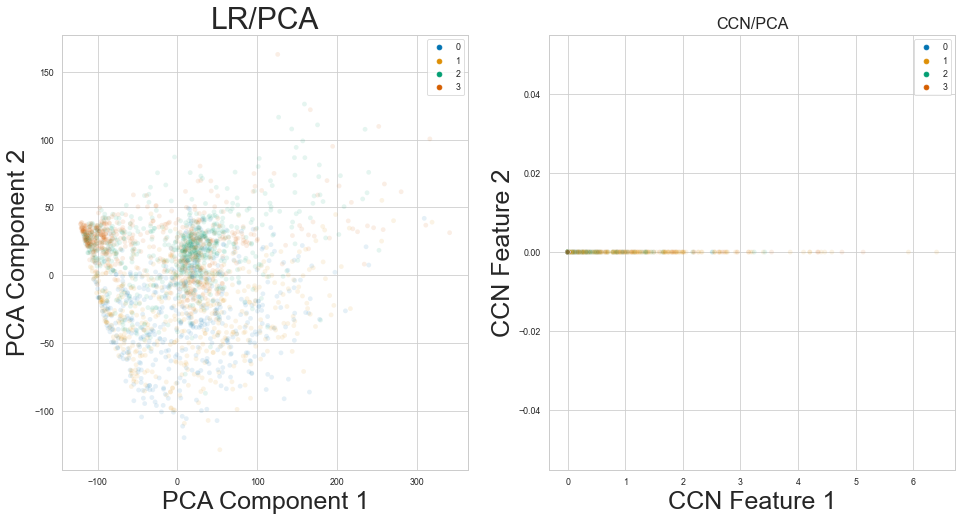

In [698]:
fig, axes = plt.subplots(1, 2, figsize=(16, 8))

sns.scatterplot(
    x=X_train_2PC[:, 0],
    y=X_train_2PC[:, 1],
    hue=y_train,
    alpha=.1,
    palette=sns.color_palette("colorblind", 4),
    ax=axes[0],
)
axes[0].set_title("LR/PCA")
axes[0].set_xlabel("PCA Component 1")
axes[0].set_ylabel("PCA Component 2")


sns.scatterplot(
    x=X_train_NN_features_2d[:, 0],
    y=X_train_NN_features_2d[:, 1],
    hue=y_train,
    alpha=.1,
    palette=sns.color_palette("colorblind", 4),
    ax=axes[1],
)

sns.set_context("paper", rc={"font.size":15,"axes.titlesize":16,"axes.labelsize":16})  
sns.set_style("whitegrid")
axes[1].set_title("CCN/PCA")
axes[1].set_xlabel("CCN Feature 1")
axes[1].set_ylabel("CCN Feature 2")
plt.savefig('CCN_PCA.jpg');

dict_keys(['loss', 'f1_m', 'val_loss', 'val_f1_m', 'lr'])


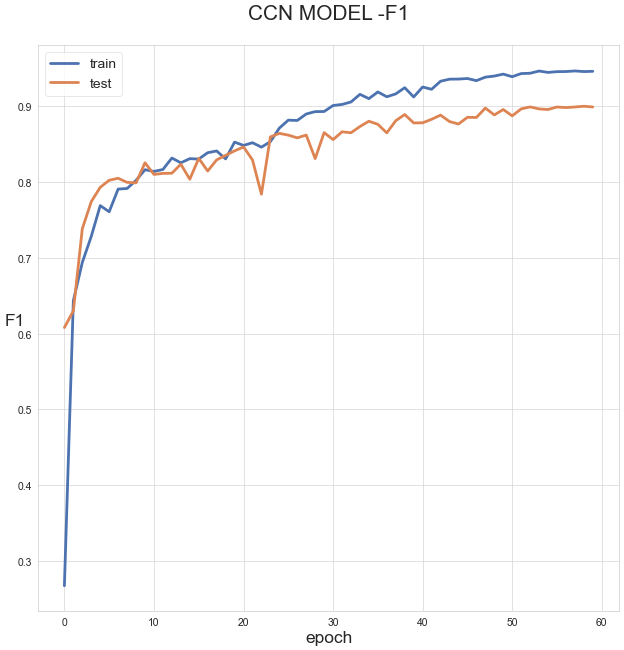

<Figure size 432x288 with 0 Axes>

In [700]:
history=run_hist
print(history.history.keys())
plt.figure(figsize=(15, 15), dpi=50)
# summarize history for accuracy
plt.plot(history.history['f1_m'], linewidth = 4)
plt.plot(history.history['val_f1_m'], linewidth = 4)
plt.title('CCN MODEL -F1\n')
plt.ylabel('F1',rotation=0)
plt.xlabel('epoch')
ax.set(ylim=(0, 100))
plt.legend(['train', 'test'], loc='upper left', fontsize = 20)
sns.set_context("paper", rc={"font.size":15,"axes.titlesize":30,"axes.labelsize":25})  
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.show()
plt.savefig('CCN_F1.jpg');

In [701]:
predictions = NN.predict(X_val)
y_pred = np.argmax(predictions, axis=1)

2022-10-28 20:28:08.440187: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


18/18 [==============================] - 0s 10ms/step


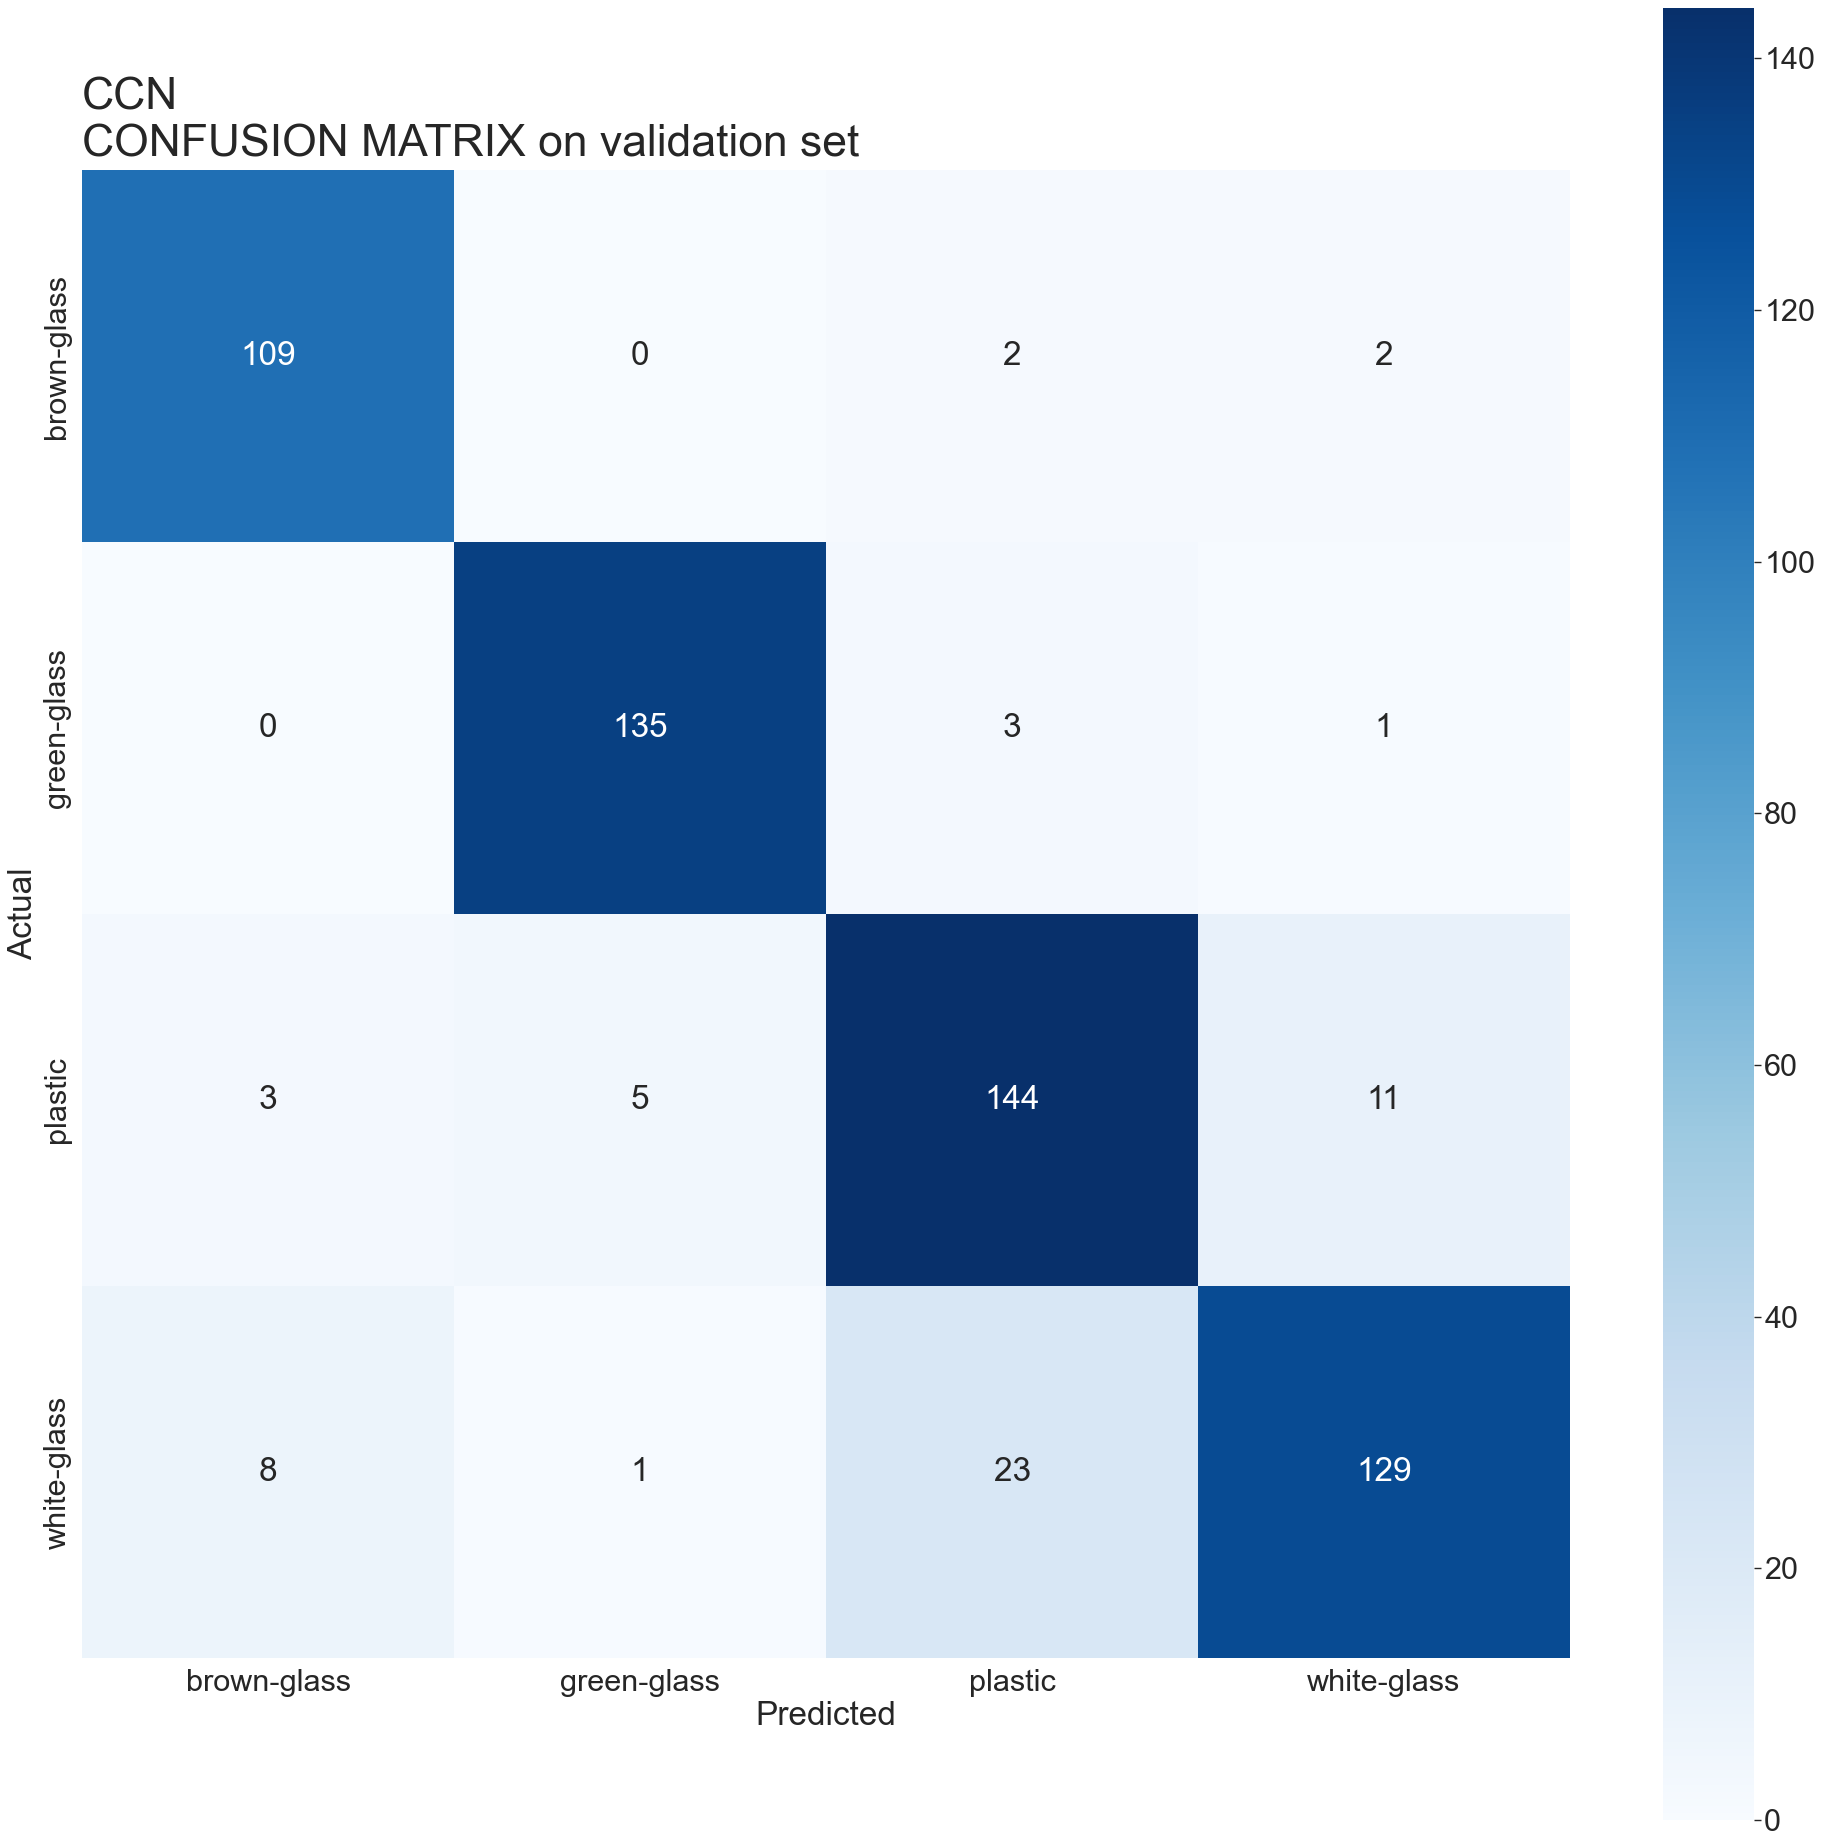

In [704]:
#Confusion Matrix
rf_confusion = confusion_matrix(y_val, y_pred)
plt.figure(figsize=(30, 30), dpi=80)
ax = plt.subplot()
sns.heatmap(rf_confusion, cmap = "Blues", annot=True, square=True, fmt=".0f")
sns.set(font_scale=2.5)

plt.xlabel('Predicted',fontsize = 30)
plt.ylabel('Actual',fontsize = 30)
ax.xaxis.set_ticklabels(['brown-glass', 'green-glass', 'plastic', 'white-glass'])
ax.yaxis.set_ticklabels(['brown-glass', 'green-glass', 'plastic', 'white-glass'])
plt.title('CCN\nCONFUSION MATRIX on validation set', fontsize = 40, loc = 'left', pad = 12)
plt.savefig('CNN_CONFUSION_MATRIX.jpg');

In [705]:
def show_and_test(image):
    i_pr = y_pred[image]
    i_va = y_val[image]
    i_li = ['brown-glass', 'green-glass', 'plastic', 'white-glass']
    i_fi = image_df.iloc[X_i.iloc[image].name].img_id
    print("Predicted: "+i_li[i_pr]+"   Actual: "+i_li[i_va]+"   File: "+i_fi)    
    img = load_img('garbage_classification/'+i_li[i_va]+'/'+i_fi)
    return img

Predicted: plastic   Actual: white-glass   File: white-glass329.jpg


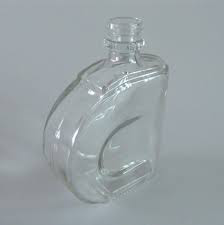

In [771]:
show_and_test(np.random.randint(0, len(y_pred)))

# Transfer Learning Models

**VGG16**

In [832]:
from tensorflow.keras.models import Model
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.layers import ZeroPadding2D, Dropout

In [833]:
# note we exclude the final dense layers by setting include_top=False,
# and add new ones to train from scratch below
base_model = tensorflow.keras.applications.VGG16(weights='imagenet', include_top=False, input_shape=X_train.shape[1:]) 

#base_model = tensorflow.keras.applications.Xception(weights='imagenet', include_top=False, input_shape=X_train.shape[1:]) 

# Freeze convolutional layers
for layer in base_model.layers:
    layer.trainable = False    

# Establish new fully connected block
x = base_model.output
#x = GlobalAveragePooling2D()(x) #experiment
x = Flatten()(x) # flatten from convolution tensor output 
#x = Dense(1024, activation='relu')(x)
x = Dense(512, activation='relu')(x) # number of layers and units are hyperparameters, as usual
x = Dense(256, activation='elu',name = '2D_layer')(x)

predictions = Dense(4, activation='softmax')(x) # should match # of classes predicted

# define formal model object to train and compile it as usual
model = Model(inputs=base_model.input, outputs=predictions)
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=[f1_m])

In [834]:
run_hist = model.fit(X_train, y_train_cat, validation_data = (X_val, y_val_cat), epochs=50, verbose=1, callbacks=[
        keras.callbacks.EarlyStopping(patience=8, verbose=1, restore_best_weights=True),
        keras.callbacks.ReduceLROnPlateau(factor=.5, patience=3, verbose=1),
    ]) 

Epoch 1/50


2022-10-28 20:59:38.655865: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


72/72 [==============================] - ETA: 0s - loss: 0.7554 - f1_m: 0.6658

2022-10-28 20:59:48.325071: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


72/72 [==============================] - 13s 165ms/step - loss: 0.7554 - f1_m: 0.6658 - val_loss: 0.4602 - val_f1_m: 0.8140 - lr: 0.0010
Epoch 2/50
72/72 [==============================] - 7s 96ms/step - loss: 0.3912 - f1_m: 0.8392 - val_loss: 0.5025 - val_f1_m: 0.8139 - lr: 0.0010
Epoch 3/50
72/72 [==============================] - 7s 96ms/step - loss: 0.3284 - f1_m: 0.8615 - val_loss: 0.6309 - val_f1_m: 0.7561 - lr: 0.0010
Epoch 4/50
72/72 [==============================] - 7s 97ms/step - loss: 0.2494 - f1_m: 0.9032 - val_loss: 0.4343 - val_f1_m: 0.8357 - lr: 0.0010
Epoch 5/50
72/72 [==============================] - 7s 97ms/step - loss: 0.1636 - f1_m: 0.9386 - val_loss: 0.4600 - val_f1_m: 0.8436 - lr: 0.0010
Epoch 6/50
72/72 [==============================] - 7s 98ms/step - loss: 0.1400 - f1_m: 0.9459 - val_loss: 0.4082 - val_f1_m: 0.8494 - lr: 0.0010
Epoch 7/50
72/72 [==============================] - 7s 98ms/step - loss: 0.1224 - f1_m: 0.9575 - val_loss: 0.5670 - val_f1_m: 0.8230 

**Validation F1 score: 0.861**

In [843]:
model.summary()

Model: "model_33"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_28 (InputLayer)       [(None, 71, 71, 3)]       0         
                                                                 
 block1_conv1 (Conv2D)       (None, 71, 71, 64)        1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 71, 71, 64)        36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 35, 35, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 35, 35, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 35, 35, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 17, 17, 128)       0  

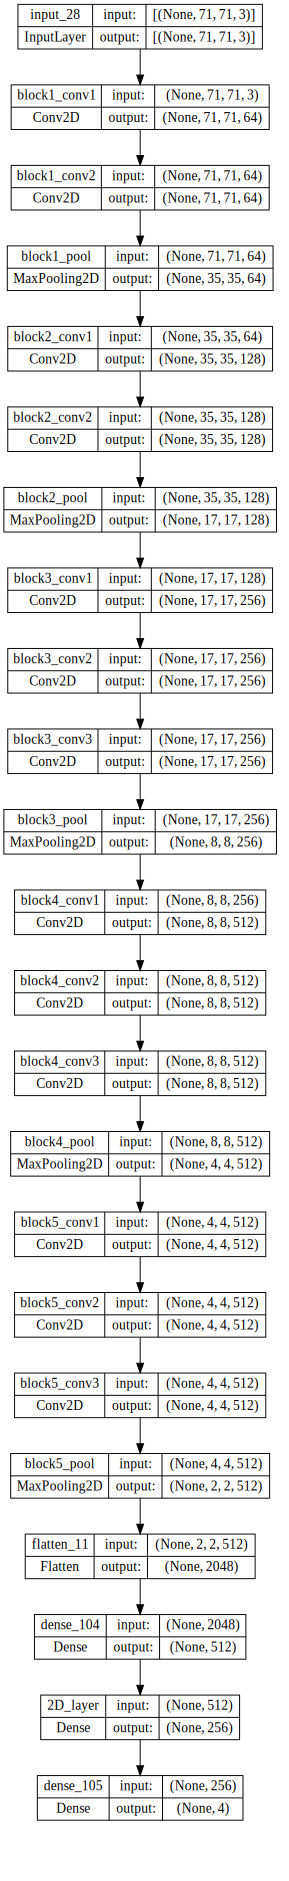

In [844]:
SVG(model_to_dot(model, show_shapes=True, dpi=70).create(prog='dot', format='svg'))

In [845]:
feature_extractor = \
    Model(inputs=model.input, outputs=model.get_layer('2D_layer').output) 

X_train_NN_features_2d = feature_extractor.predict(X_train)
X_test_NN_features_2d = feature_extractor.predict(X_val)

2022-10-28 21:03:15.850020: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


18/18 [==============================] - 1s 72ms/step


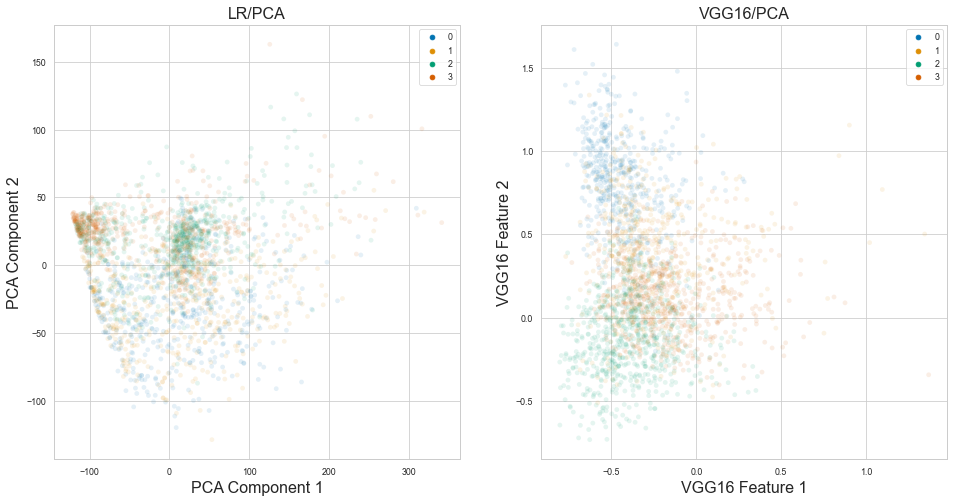

In [847]:
fig, axes = plt.subplots(1, 2, figsize=(16, 8))

sns.scatterplot(
    x=X_train_2PC[:, 0],
    y=X_train_2PC[:, 1],
    hue=y_train,
    alpha=.1,
    palette=sns.color_palette("colorblind", 4),
    ax=axes[0],
)
axes[0].set_title("LR/PCA")
axes[0].set_xlabel("PCA Component 1")
axes[0].set_ylabel("PCA Component 2")


sns.scatterplot(
    x=X_train_NN_features_2d[:, 0],
    y=X_train_NN_features_2d[:, 1],
    hue=y_train,
    alpha=.1,
    palette=sns.color_palette("colorblind", 4),
    ax=axes[1],
)
sns.set_context("paper", rc={"font.size":15,"axes.titlesize":16,"axes.labelsize":16})  
sns.set_style("whitegrid")
axes[1].set_title("VGG16/PCA")
axes[1].set_xlabel("VGG16 Feature 1")
axes[1].set_ylabel("VGG16 Feature 2")
plt.savefig('VGG16_PCA.jpg');

dict_keys(['loss', 'f1_m', 'val_loss', 'val_f1_m', 'lr'])


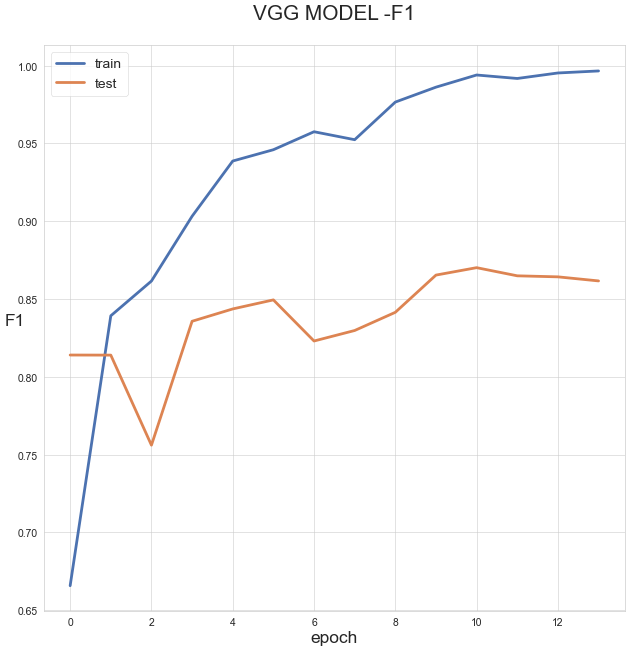

<Figure size 432x288 with 0 Axes>

In [850]:
history=run_hist
print(history.history.keys())
plt.figure(figsize=(15, 15), dpi=50)
# summarize history for accuracy
plt.plot(history.history['f1_m'], linewidth = 4)
plt.plot(history.history['val_f1_m'], linewidth = 4)
plt.title('VGG16 MODEL -F1\n')
plt.ylabel('F1',rotation=0)
plt.xlabel('epoch')
ax.set(ylim=(0, 100))
plt.legend(['train', 'test'], loc='upper left', fontsize = 20)
sns.set_context("paper", rc={"font.size":15,"axes.titlesize":30,"axes.labelsize":25})  
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.show()
plt.savefig('VGG16_F1.jpg');

In [851]:
predictions = model.predict(X_val)
y_pred = np.argmax(predictions, axis=1)

18/18 [==============================] - 1s 62ms/step


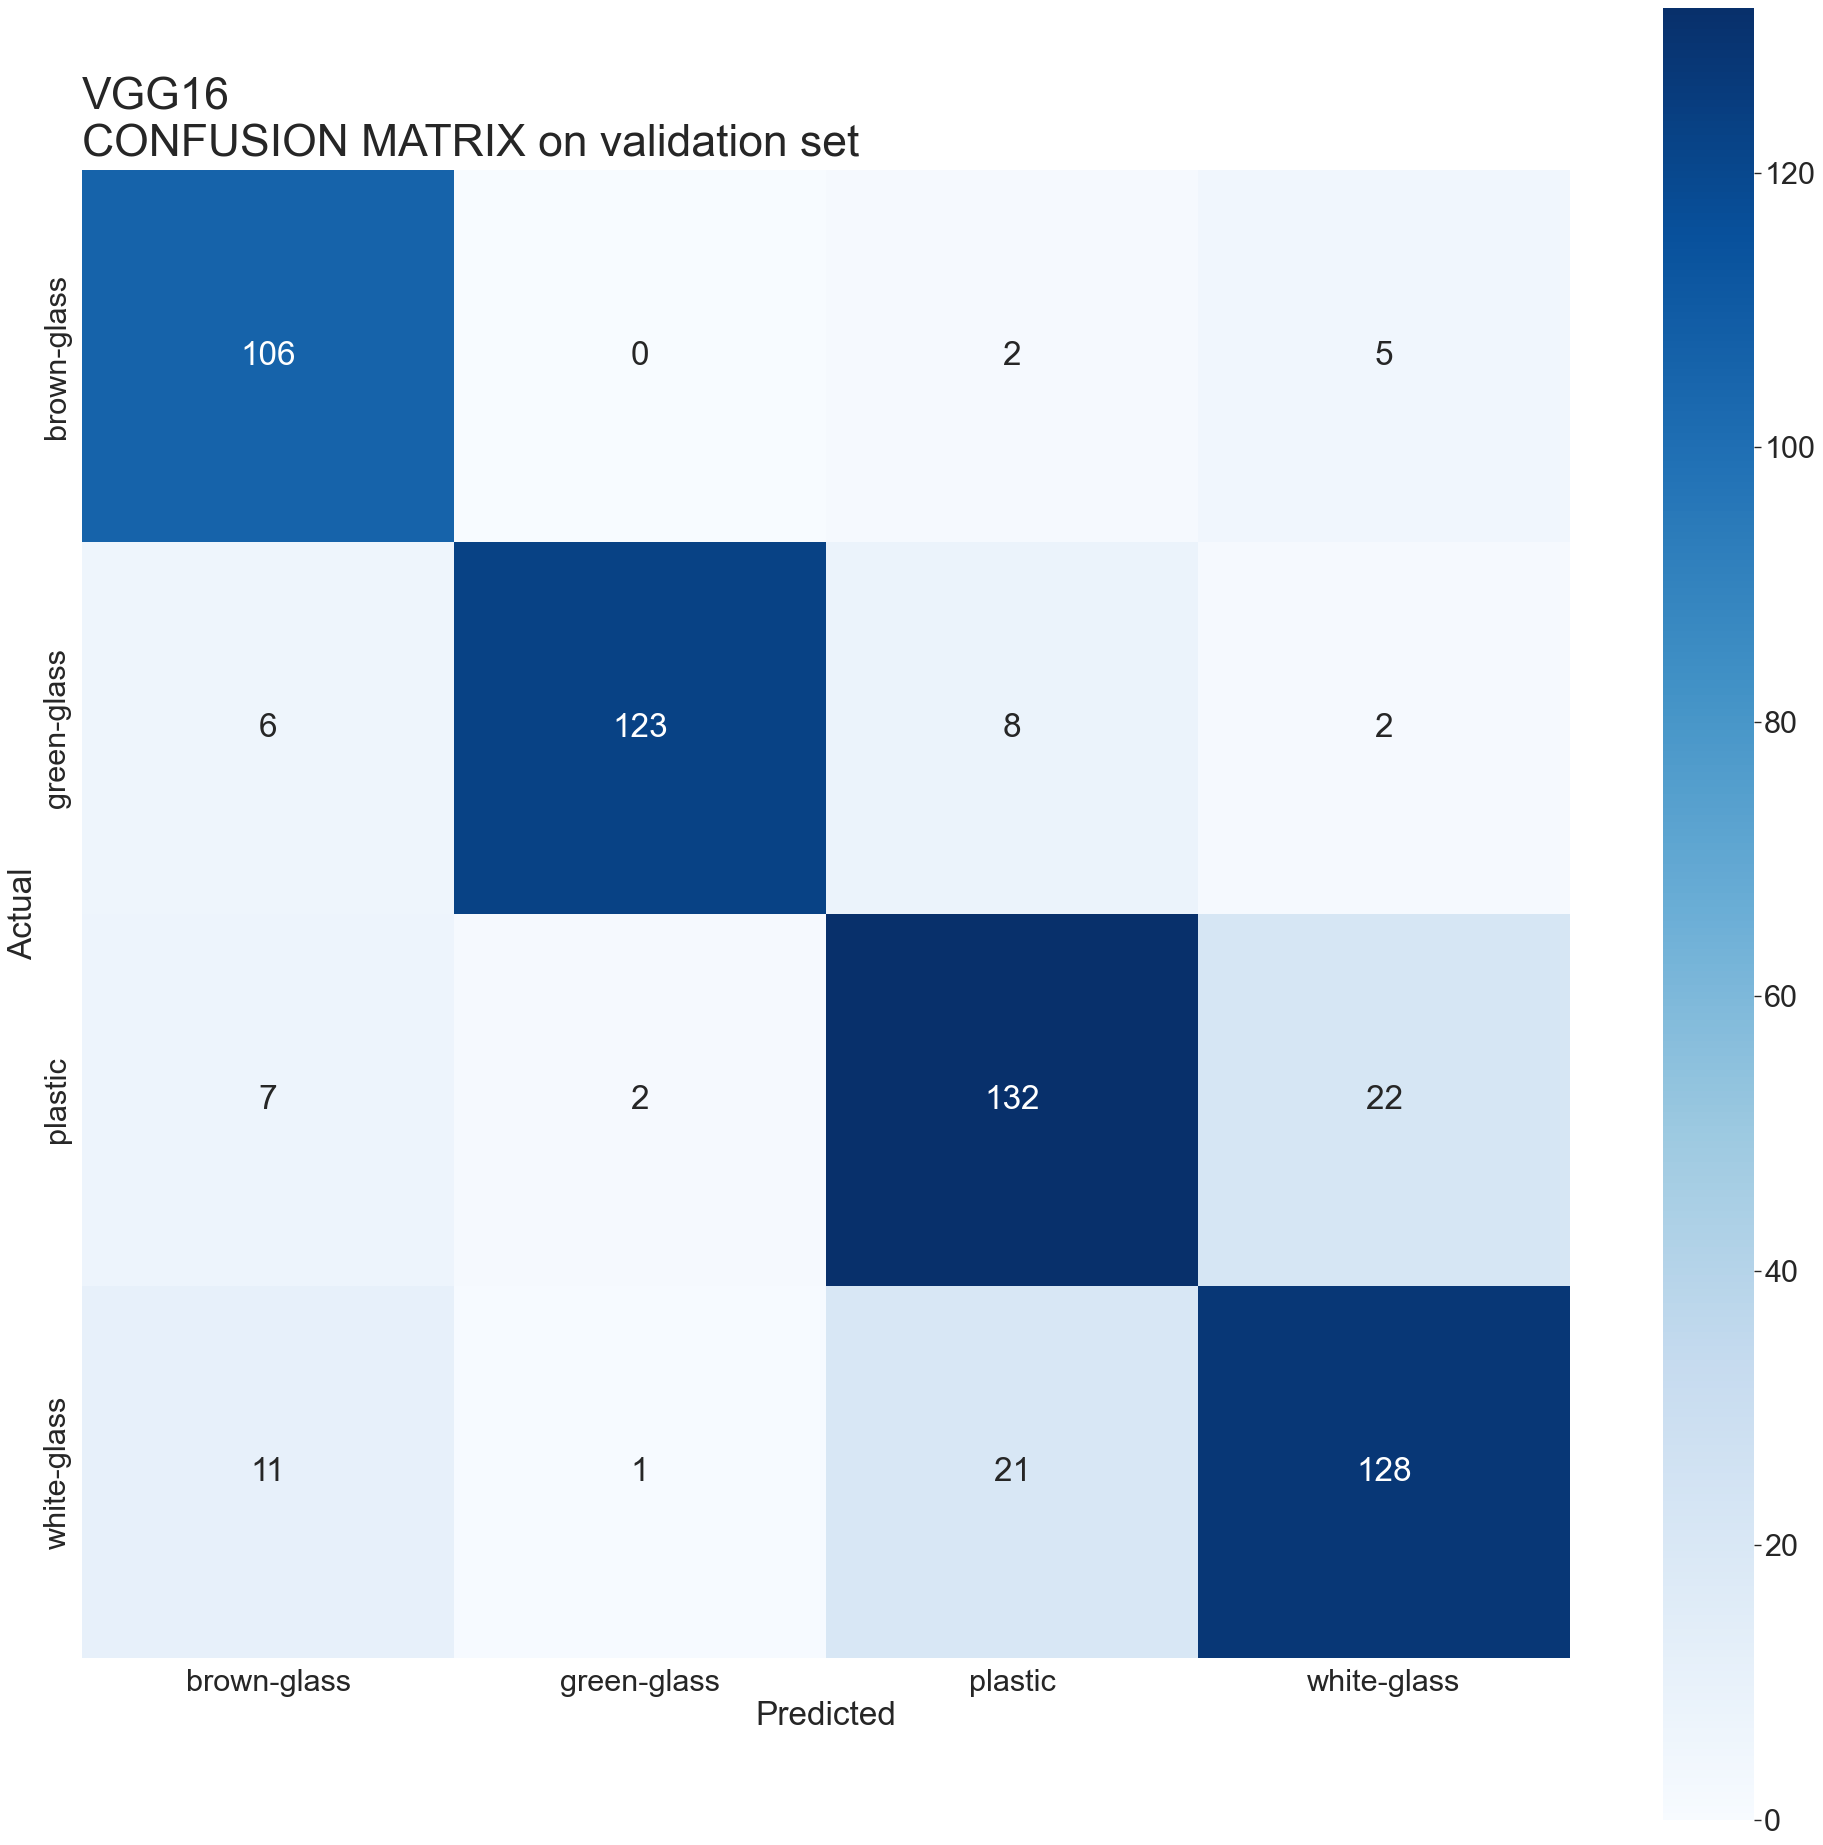

In [854]:
#Confusion Matrix
rf_confusion = confusion_matrix(y_val, y_pred)
plt.figure(figsize=(30, 30), dpi=80)
ax = plt.subplot()
sns.heatmap(rf_confusion, cmap = "Blues", annot=True, square=True, fmt=".0f")
sns.set(font_scale=2.5)

plt.xlabel('Predicted',fontsize = 30)
plt.ylabel('Actual',fontsize = 30)
ax.xaxis.set_ticklabels(['brown-glass', 'green-glass', 'plastic', 'white-glass'])
ax.yaxis.set_ticklabels(['brown-glass', 'green-glass', 'plastic', 'white-glass'])
plt.title('VGG16\nCONFUSION MATRIX on validation set', fontsize = 40, loc = 'left', pad = 12)
plt.savefig('VGG16_CONFUSION_MATRIX.jpg');

In [855]:
def show_and_test(image):
    i_pr = y_pred[image]
    i_va = y_val[image]
    i_li = ['brown-glass', 'green-glass', 'plastic', 'white-glass']
    i_fi = image_df.iloc[X_i.iloc[image].name].img_id
    print("Predicted: "+i_li[i_pr]+"   Actual: "+i_li[i_va]+"   File: "+i_fi)    
    img = load_img('garbage_classification/'+i_li[i_va]+'/'+i_fi)
    return img

Predicted: plastic   Actual: white-glass   File: white-glass217.jpg


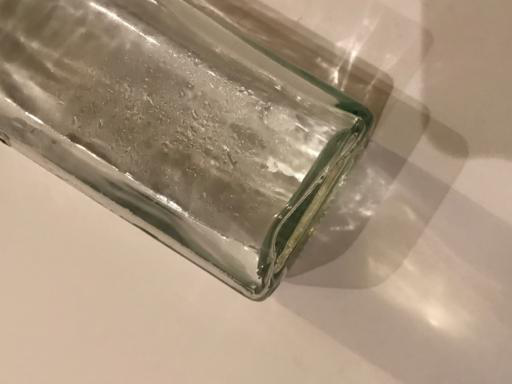

In [884]:
show_and_test(np.random.randint(0, len(y_pred)))

**VGG19**

In [885]:
# note we exclude the final dense layers by setting include_top=False,
# and add new ones to train from scratch below
base_model = tensorflow.keras.applications.VGG19(weights='imagenet', include_top=False, input_shape=X_train.shape[1:]) 

#base_model = tensorflow.keras.applications.Xception(weights='imagenet', include_top=False, input_shape=X_train.shape[1:]) 

# Freeze convolutional layers
for layer in base_model.layers:
    layer.trainable = False    

# Establish new fully connected block
x = base_model.output
#x = GlobalAveragePooling2D()(x) #experiment
x = Flatten()(x) # flatten from convolution tensor output 
#x = Dense(512, activation='relu')(x)
x = Dense(512, activation='relu')(x) # number of layers and units are hyperparameters, as usual
x = Dense(256, activation='elu')(x)

predictions = Dense(4, activation='softmax')(x) # should match # of classes predicted

# define formal model object to train and compile it as usual
model = Model(inputs=base_model.input, outputs=predictions)
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=[f1_m])

In [888]:
run_hist = model.fit(X_train, y_train_cat, validation_data = (X_val, y_val_cat), epochs=50, verbose=1, callbacks=[
        keras.callbacks.EarlyStopping(patience=8, verbose=1, restore_best_weights=True),
        keras.callbacks.ReduceLROnPlateau(factor=.5, patience=3, verbose=1),
    ]) 

Epoch 1/50
72/72 [==============================] - 8s 111ms/step - loss: 0.1860 - f1_m: 0.9318 - val_loss: 0.4653 - val_f1_m: 0.8273 - lr: 2.5000e-04
Epoch 2/50
72/72 [==============================] - 8s 115ms/step - loss: 0.1541 - f1_m: 0.9397 - val_loss: 0.4242 - val_f1_m: 0.8347 - lr: 2.5000e-04
Epoch 3/50
72/72 [==============================] - 8s 116ms/step - loss: 0.1273 - f1_m: 0.9554 - val_loss: 0.4241 - val_f1_m: 0.8435 - lr: 2.5000e-04
Epoch 4/50
72/72 [==============================] - 9s 118ms/step - loss: 0.1088 - f1_m: 0.9608 - val_loss: 0.4400 - val_f1_m: 0.8390 - lr: 2.5000e-04
Epoch 5/50
72/72 [==============================] - ETA: 0s - loss: 0.1023 - f1_m: 0.9634
Epoch 5: ReduceLROnPlateau reducing learning rate to 0.0001250000059371814.
72/72 [==============================] - 8s 114ms/step - loss: 0.1023 - f1_m: 0.9634 - val_loss: 0.5134 - val_f1_m: 0.8374 - lr: 2.5000e-04
Epoch 6/50
72/72 [==============================] - 8s 107ms/step - loss: 0.0733 - f1_m: 0

**Validation F1 score: 0.848**

**Xception**

In [902]:
from tensorflow.keras.models import Model
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.layers import ZeroPadding2D, Dropout

In [903]:
# note we exclude the final dense layers by setting include_top=False,
# and add new ones to train from scratch below

base_model = tensorflow.keras.applications.Xception(weights='imagenet', include_top=False, input_shape=X_train.shape[1:]) 

# Freeze convolutional layers
for layer in base_model.layers:
    layer.trainable = False    

# Establish new fully connected block
x = base_model.output
#x = GlobalAveragePooling2D()(x) #experiment
x = Flatten()(x) # flatten from convolution tensor output 
#x = Dense(1024, activation='relu')(x)
x = Dense(512, activation='relu')(x) # number of layers and units are hyperparameters, as usual
x = Dense(256, activation='elu',name = '2D_layer')(x)

predictions = Dense(4, activation='softmax')(x) # should match # of classes predicted

# define formal model object to train and compile it as usual
model = Model(inputs=base_model.input, outputs=predictions)
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=[f1_m])

In [904]:
run_hist = model.fit(X_train, y_train_cat, validation_data = (X_val, y_val_cat), epochs=50, verbose=1, callbacks=[
        keras.callbacks.EarlyStopping(patience=8, verbose=1, restore_best_weights=True),
        keras.callbacks.ReduceLROnPlateau(factor=.5, patience=3, verbose=1),
    ]) 

Epoch 1/50


2022-10-28 21:16:23.690500: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


72/72 [==============================] - ETA: 0s - loss: 1.6175 - f1_m: 0.6158

2022-10-28 21:16:35.205874: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


72/72 [==============================] - 17s 196ms/step - loss: 1.6175 - f1_m: 0.6158 - val_loss: 0.8126 - val_f1_m: 0.7029 - lr: 0.0010
Epoch 2/50
72/72 [==============================] - 11s 147ms/step - loss: 0.4821 - f1_m: 0.8109 - val_loss: 0.6068 - val_f1_m: 0.7803 - lr: 0.0010
Epoch 3/50
72/72 [==============================] - 9s 131ms/step - loss: 0.3704 - f1_m: 0.8632 - val_loss: 0.5643 - val_f1_m: 0.7822 - lr: 0.0010
Epoch 4/50
72/72 [==============================] - 9s 123ms/step - loss: 0.2373 - f1_m: 0.9088 - val_loss: 0.7630 - val_f1_m: 0.7514 - lr: 0.0010
Epoch 5/50
72/72 [==============================] - 9s 125ms/step - loss: 0.1402 - f1_m: 0.9464 - val_loss: 0.6676 - val_f1_m: 0.7881 - lr: 0.0010
Epoch 6/50
72/72 [==============================] - ETA: 0s - loss: 0.0849 - f1_m: 0.9723
Epoch 6: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
72/72 [==============================] - 9s 123ms/step - loss: 0.0849 - f1_m: 0.9723 - val_loss: 0.9569 - va

**Validation F1 score: 0.792**

**EfficientNetV2L**

In [905]:
# note we exclude the final dense layers by setting include_top=False,
# and add new ones to train from scratch below
base_model = tensorflow.keras.applications.EfficientNetV2L(weights='imagenet', include_top=False, input_shape=X_train.shape[1:]) 

#base_model = tensorflow.keras.applications.Xception(weights='imagenet', include_top=False, input_shape=X_train.shape[1:]) 

# Freeze convolutional layers
for layer in base_model.layers:
    layer.trainable = False    

# Establish new fully connected block
x = base_model.output
#x = GlobalAveragePooling2D()(x) #experiment
x = Flatten()(x) # flatten from convolution tensor output 
#x = Dense(512, activation='relu')(x)
x = Dense(512, activation='relu')(x) # number of layers and units are hyperparameters, as usual
x = Dense(256, activation='elu')(x)

predictions = Dense(4, activation='softmax')(x) # should match # of classes predicted

# define formal model object to train and compile it as usual
model = Model(inputs=base_model.input, outputs=predictions)
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=[f1_m])

In [906]:
model.fit(X_train, y_train_cat, validation_data = (X_val, y_val_cat), epochs=50, verbose=1, callbacks=[
        keras.callbacks.EarlyStopping(patience=8, verbose=1, restore_best_weights=True),
        keras.callbacks.ReduceLROnPlateau(factor=.5, patience=3, verbose=1),
    ]) 

Epoch 1/50


2022-10-28 21:18:34.201153: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


72/72 [==============================] - ETA: 0s - loss: 2.1025 - f1_m: 0.1088

2022-10-28 21:19:46.245704: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


72/72 [==============================] - 115s 1s/step - loss: 2.1025 - f1_m: 0.1088 - val_loss: 1.4771 - val_f1_m: 0.0419 - lr: 0.0010
Epoch 2/50
72/72 [==============================] - 37s 517ms/step - loss: 1.4198 - f1_m: 0.0701 - val_loss: 1.4025 - val_f1_m: 0.0903 - lr: 0.0010
Epoch 3/50
72/72 [==============================] - 31s 435ms/step - loss: 1.3547 - f1_m: 0.0712 - val_loss: 1.7260 - val_f1_m: 0.0446 - lr: 0.0010
Epoch 4/50
72/72 [==============================] - 37s 520ms/step - loss: 1.3071 - f1_m: 0.0598 - val_loss: 1.4066 - val_f1_m: 0.2758 - lr: 0.0010
Epoch 5/50
72/72 [==============================] - 33s 460ms/step - loss: 1.2787 - f1_m: 0.1121 - val_loss: 1.3893 - val_f1_m: 0.2674 - lr: 0.0010
Epoch 6/50
72/72 [==============================] - 31s 435ms/step - loss: 1.2810 - f1_m: 0.1412 - val_loss: 1.4872 - val_f1_m: 0.0000e+00 - lr: 0.0010
Epoch 7/50
72/72 [==============================] - 39s 545ms/step - loss: 1.2471 - f1_m: 0.0974 - val_loss: 1.2486 - val

**Validation F1 score: 0.310, Training F1 score: 0,213**